In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase
from ase.build import bulk

from mpl_toolkits import mplot3d
import mpi4py

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

In [35]:
# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)
# Populate Bath cell with isotopes
diamond.add_isotopes(('13C', 0.011))
# diamond.isotopes['C']['14C'] = 0.001
# Set z-direction of the bath (defect)
diamond.zdir = [1, 1, 1]
# Generate spin bath
### Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

# # Note, that because the 14C isotope doesn’t have a spin, PyCCE does not find it in common isotopes, and raises a warning. We have to provide SpinType for it separately, or define the properties as follows:
# atoms['14C'].gyro = 0
# atoms['14C'].spin = 0

# Setting up the Simulator

### Parameters of CCE calculations engine
# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

In [36]:
print('Cell\n', diamond.cell)
print('\nAtoms\n', diamond.atoms)

Cell
 [[ 2.81557 -0.75443 -2.06114]
 [-0.75443  2.81557 -2.06114]
 [ 2.06114  2.06114  2.06114]]

Atoms
 defaultdict(<class 'list'>, {'C': [array([0., 0., 0.]), array([0.25, 0.25, 0.25]), array([0. , 0.5, 0.5]), array([0.25, 0.75, 0.75]), array([0.5, 0. , 0.5]), array([0.75, 0.25, 0.75]), array([0.5, 0.5, 0. ]), array([0.75, 0.75, 0.25])]})


In [37]:
##########################################################################################
# ZFS Parametters of NV center in diamond
#############################################
# ZFS D parameter
# start = 1
# stop = 2.8e9
start = 1.334 * 1e3
stop = 1.334 * 1e7
# start = 1e-20
# stop = 1e-19
num = 2

D_list = np.logspace(np.log10(start), np.log10(stop), num=num) # in kHz


# D_list = np.linspace(start, stop, num=num)

# D_list = [1] # Note for later, very low values of D give remarkably high coherence??

# D_list = [19390]
print("D_list: ", D_list)
#############################################
# ZFS E parameter
E_start = 18409
E_stop = 184092
E_num = 2
E_list = np.logspace(np.log10(E_start), np.log10(E_stop), num=E_num) 
# E_list = np.linspace(E_start, E_stop, num=E_num)
# E_list = [0]

# E_list = [139.24798] # Note for later, this value of E give remarkably high coherence??

##########################################################################################
### Other parameters
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
            ('13C',  1 / 2,  6.72828),
            ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

# Time points
time_space = np.linspace(0, 1, 101)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 0

##########################################################################################
# Mag. Field (Bx By Bz)
b = np.array([0,0, 0])  # in G
##########################################################################################


coherence_list = []
coherence_dict = {}

for idx, D in enumerate(D_list):
    print(str(1+idx) + "/" + str(len(D_list)))
    # print("D: ", D)
    for E in E_list:
        # Define the central spin
        nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

        # print(nv)

        # Setting the Simulator object
        ### Setting the runner engine
        calc = pc.Simulator(spin=nv, bath=atoms,
                            D=D, E=E,
                            r_bath=r_bath, r_dipole=r_dipole, order=order)
        # print(calc)
        # Taking advantage of subclassing np.ndarray we can change in situ the quadrupole tensor of the Nitrogen nuclear spin.
        # nspin = calc.bath
        # # Set model quadrupole tensor at N atom
        # quad = np.asarray([[-2.5, 0, 0],
        #                    [0, -2.5, 0],
        #                    [0, 0,  5.0]]) * 1e3 * 2 * np.pi

        # nspin['Q'][nspin['N'] == '14N'] = quad
        # print(calc)

        # Hahn-echo pulse sequence
        pulse_sequence = [pc.Pulse('x',np.pi)]
        # pulse_sequence += [pc.Pulse('z',np.pi)]
        # pulse_sequence += [pc.Pulse('y',np.pi)]


        # Calculate coherence function
        l_generatilze = calc.compute(time_space, 
                                    #  magnetic_field=b,
                                    # pulses=pulse_sequence,
                                    method='gcce', quantity='coherence',
                                    nbstates=5, seed=seed,
                                    parallel=True,
                                    )
        
        # At the end of your inner loop:
        key = (D, E)
        coherence_dict[key] = np.abs(l_generatilze)

D_list:  [    1334. 13340000.]
1/2


2/2


In [38]:
print(coherence_dict.keys())

dict_keys([(1333.9999999999993, 18409.0), (1333.9999999999993, 184092.0000000001), (13339999.999999994, 18409.0), (13339999.999999994, 184092.0000000001)])


In [41]:
# mock = calc

# # add 3D axis
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(projection='3d')

# # We want to visualize the smaller bath
# data = mock.bath

# # First plot the positions of the bath
# colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
# ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# # Plot all pairs of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 2
# # for c in mock.clusters[2]:
# #     ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# # Plot all triplets of nuclear spins, which are contained
# # in the calc.clusters dictionary under they key 3
# for c in mock.clusters[3]:
#     ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

# ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

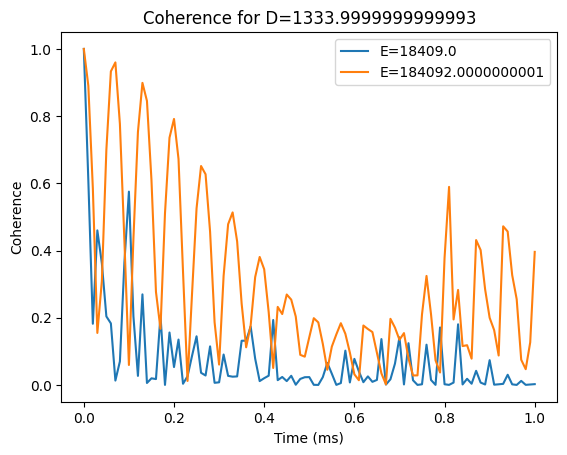

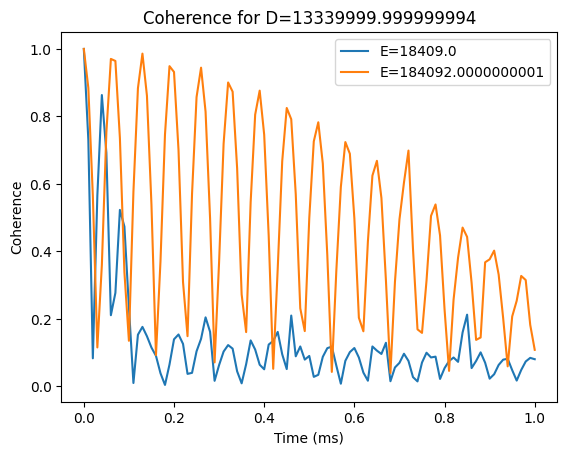

In [42]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Iterate over each unique D value
for D in unique_D_values:
    # plt.figure(figsize=(10,7))
    for E in unique_E_values:
        coherence_for_DE = coherence_dict[(D, E)]
        plt.plot(time_space, coherence_for_DE, label=f'E={E}')
    
    # plt.ylim(0,1)
    plt.title(f'Coherence for D={D}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Coherence')
    plt.legend()
    plt.show()

/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_11370/3507103810.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(time / T2) ** beta)
/var/folders/lw/t9zjwk2n3gz9vr06983n8b040000gn/T/ipykernel_11370/3507103810.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(time / T2) ** beta)


Error fitting for D = 13339999.999999994 kHz: Optimal parameters not found: Number of calls to function has reached maxfev = 600.


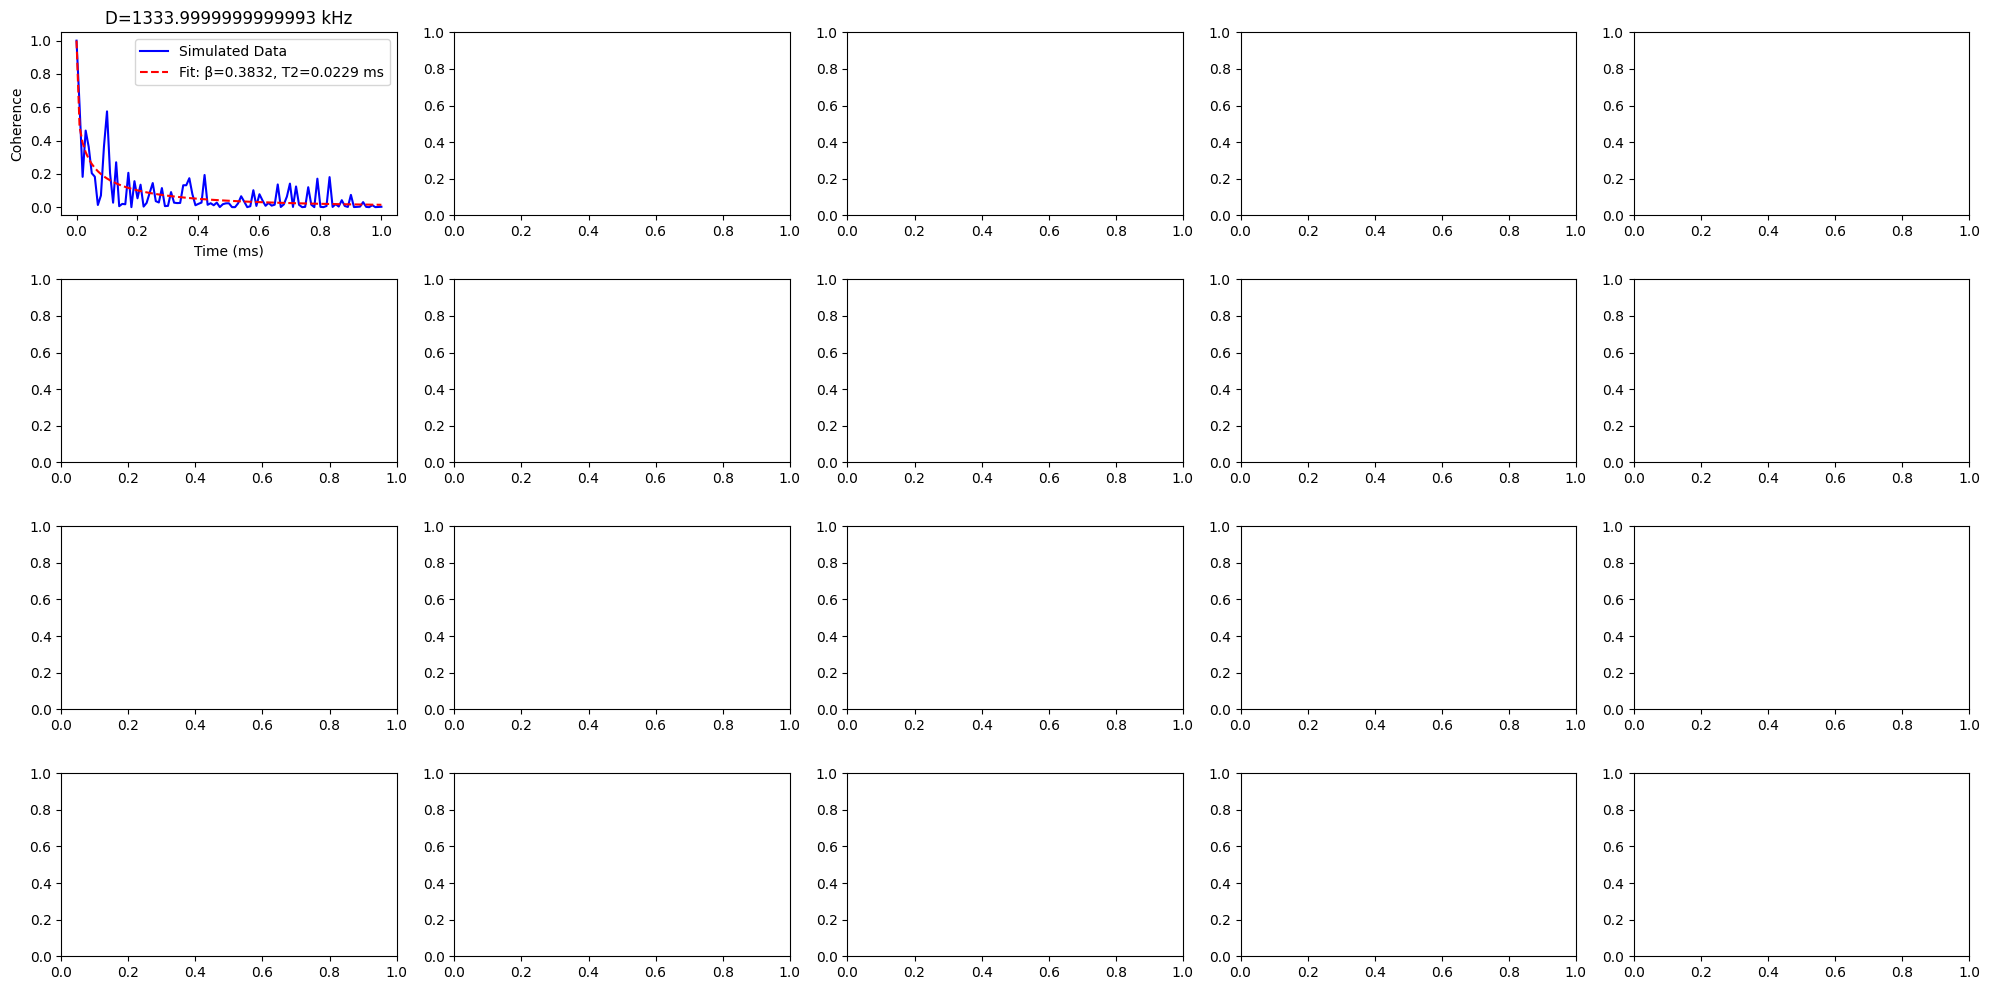

D = 1333.9999999999993 kHz: T2 = 0.0229 ms


TypeError: unsupported format string passed to NoneType.__format__

In [43]:
def coherence_time_func(time, beta, T2):
    return np.exp(-(time / T2) ** beta)

from scipy.optimize import curve_fit

# Choose a reference E value (smallest E in this case)
ref_E_value = min(unique_E_values)

# Continue as before
T2_values = {}
beta_values = {}

rows = 4
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
axes = axes.ravel()

for idx, D in enumerate(unique_D_values):
    # Extract coherence data for the given D and reference E value
    coherence_data = coherence_dict[(D, ref_E_value)]

    try:
        popt, _ = curve_fit(coherence_time_func, time_space, coherence_data, p0=(1, 1))
        beta_fitted, T2_fitted = popt
        beta_values[D] = beta_fitted
        T2_values[D] = T2_fitted

        ax = axes[idx]
        ax.plot(time_space, coherence_data, 'b-', label='Simulated Data')
        ax.plot(time_space, coherence_time_func(time_space, *popt), 'r--', label=f'Fit: β={beta_fitted:.4f}, T2={T2_fitted:.4f} ms')
        ax.set_title(f'D={D} kHz')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Coherence')
        ax.legend()

    except Exception as e:
        print(f"Error fitting for D = {D} kHz: {e}")
        beta_values[D] = None
        T2_values[D] = None

plt.tight_layout()
plt.show()

for D, T2 in T2_values.items():
    print(f"D = {D} kHz: T2 = {T2:.4f} ms")


In [ ]:
print(coherence_dict.values())

dict_values([masked_array(data=[0.9999999999998169, 0.8172607302502263,
                   0.41538138323791685, 0.10065993905343877,
                   0.09536490228181425, 0.5606272666116001,
                   0.7058324928179467, 0.7803514900859465,
                   0.6155353036924619, 0.35336055785970405,
                   0.19047236627693845, 0.10318457513881825,
                   0.10804101813421566, 0.3498125352625871,
                   0.25421565618988157, 0.2034496541357935,
                   0.008725790109102466, 0.017981539960105677,
                   0.027185889173777494, 0.028362532301662816,
                   0.11423252958999962, 0.03098903424817003,
                   0.05379576882872683, 0.05950429610221791,
                   0.0017275548677242113, 0.026139265075097198,
                   0.15096231737835333, 0.05737773865087199,
                   0.07565848736626826, 0.005209306161266815,
                   0.15521403477697565, 0.01818406080846698,
           

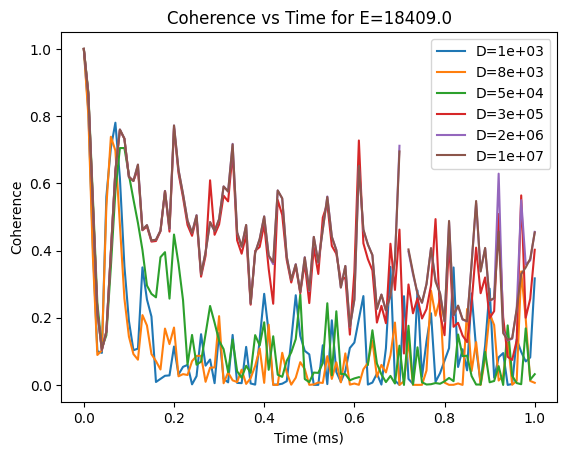

In [ ]:
# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_for_smallest_E = [coherence_dict[(D, smallest_E)] for D in unique_D_values]

plt.figure()
for i, D_val in enumerate(unique_D_values):
    plt.plot(time_space, coherence_for_smallest_E[i], label=f'D={D_val:.0e}')
    
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')
plt.legend()
plt.title(f'Coherence vs Time for E={smallest_E}')
# plt.ylim(0,10)
plt.show()


In [ ]:
# # Extract unique D values
# unique_D_values = sorted(coherence_dict.keys())

# # Extract coherence values for the smallest D value
# smallest_D = min(unique_D_values)
# coherence_for_smallest_D = [coherence_dict[D] for D in unique_D_values]

# plt.figure()
# for i, D_val in enumerate(unique_D_values):
#     plt.plot(time_space, coherence_for_smallest_D[i], label=f'D={D_val:.0e}')
    
# plt.xlabel('Time (ms)')
# plt.ylabel('Coherence')
# plt.legend()
# plt.title(f'Coherence vs Time for D={smallest_D}')
# plt.show()


In [ ]:
# # Visualize difference in coherence for different E values

# # Extract unique D and E values
# unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
# unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))


# # Reference coherence for smallest E
# ref_E_value = min(E_list)

# # Iterate over each unique D value
# for D in unique_D_values:
#     # The reference coherence changes for each D. Update the ref_coherence for each D.
#     ref_coherence = coherence_dict[(D, ref_E_value)]

#     # plt.figure(figsize=(10,7))
#     for E in unique_E_values:
#         if E == ref_E_value:  # Don't plot the difference for the reference E
#             continue
#         coherence_for_DE = coherence_dict[(D, E)]
        
#         # Plot the difference
#         difference = coherence_for_DE - ref_coherence
#         plt.plot(time_space, difference, label=f'ΔE={E}')
    
#     plt.title(f'Coherence Difference from E={ref_E_value} for D={D}')
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Difference in Coherence')
#     plt.legend()
#     plt.show()


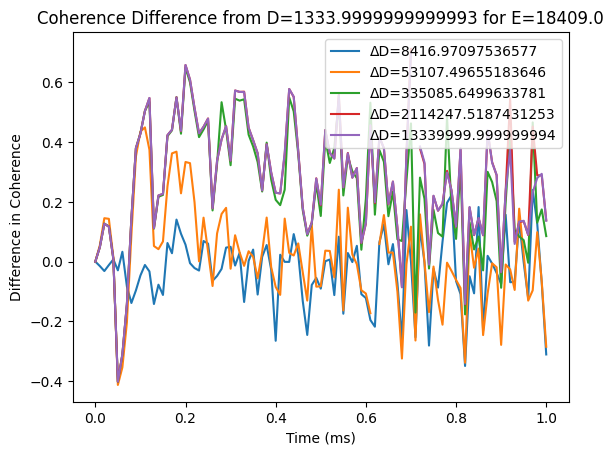

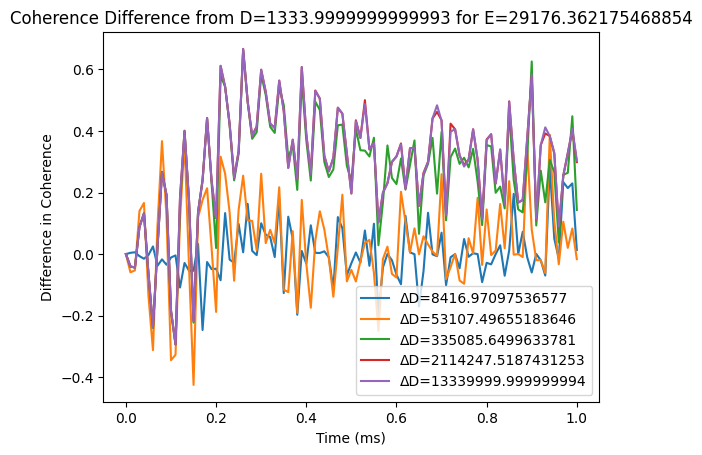

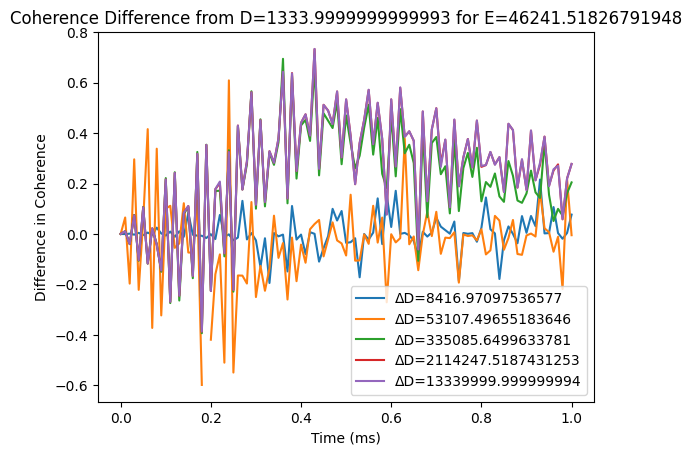

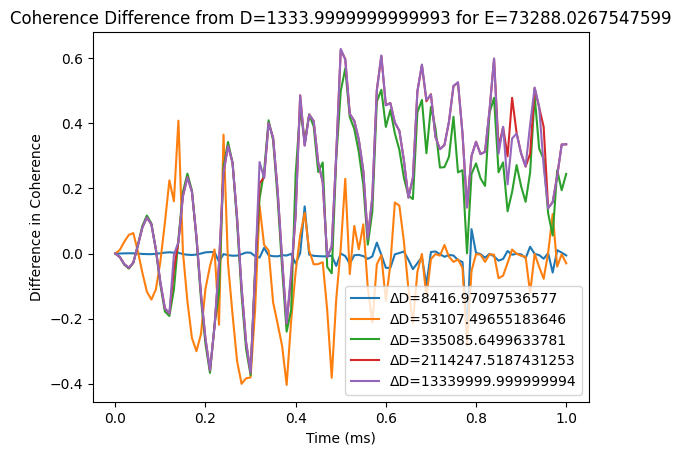

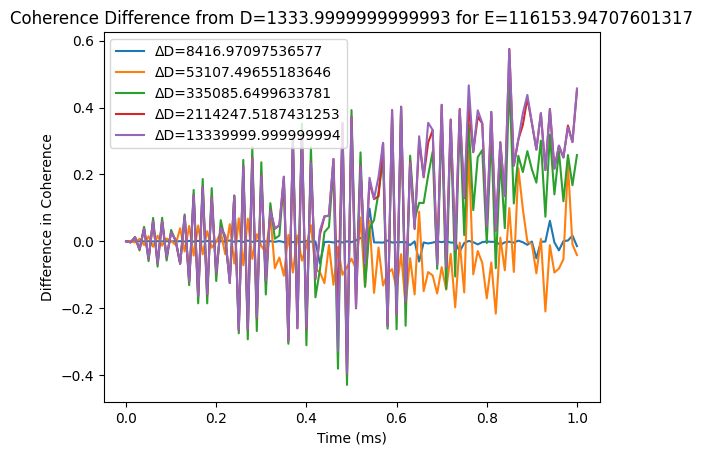

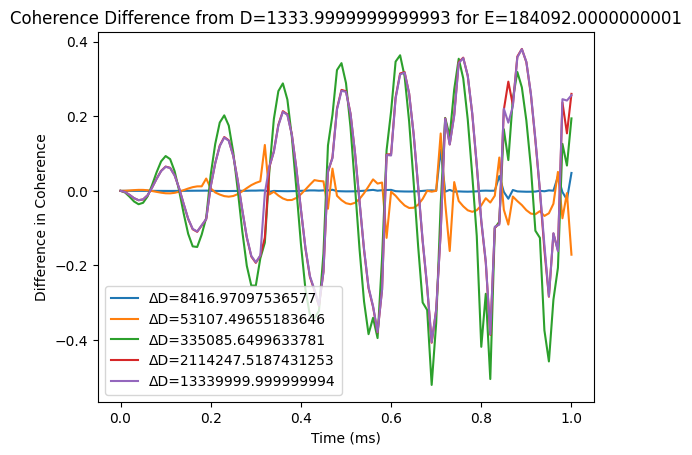

In [ ]:
# Visualize difference in coherence for different D values

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest D
ref_D_value = min(unique_D_values)

# Iterate over each unique E value
for E in unique_E_values:
    # The reference coherence changes for each E. Update the ref_coherence for each E.
    ref_coherence = coherence_dict[(ref_D_value, E)]

    # plt.figure(figsize=(10,7))
    for D in unique_D_values:
        if D == ref_D_value:  # Don't plot the difference for the reference D
            continue
        coherence_for_DE = coherence_dict[(D, E)]
        
        # Plot the difference
        difference = coherence_for_DE - ref_coherence
        plt.plot(time_space, difference, label=f'ΔD={D}')
    
    plt.title(f'Coherence Difference from D={ref_D_value} for E={E}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Difference in Coherence')
    plt.legend()
    plt.show()


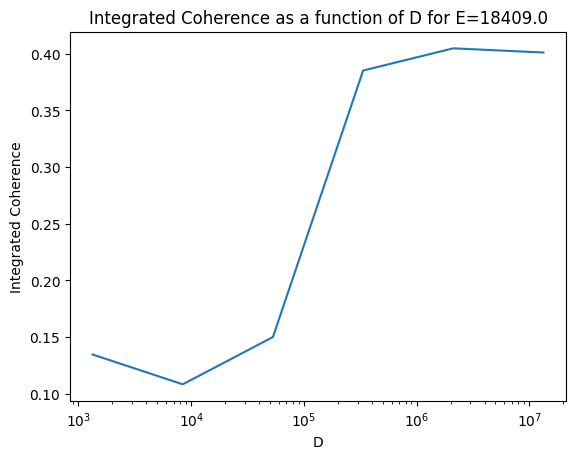

In [ ]:
def integrate(x_list, y_list):
    """
    Integrate a list of y values with respect to a list of x values.
    """
    return np.trapz(y_list, x_list)

# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Reference coherence for smallest E
ref_E_value = min(E_list)

# Integrate each coherence curve for each D at the reference E value
integrated_coherence = [integrate(time_space, coherence_dict[(D, ref_E_value)]) for D in unique_D_values]

# Plot the integrated coherence as a function of D
plt.figure()
plt.semilogx(unique_D_values, integrated_coherence)
plt.xlabel('D')
plt.ylabel('Integrated Coherence')
plt.title(f'Integrated Coherence as a function of D for E={ref_E_value}')
plt.show()


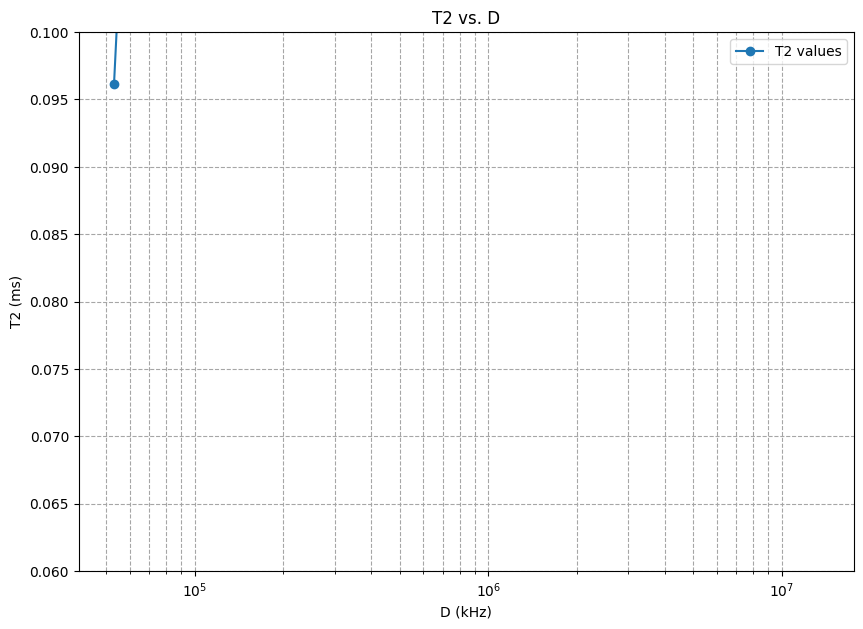

In [ ]:
# Extract D values and corresponding T2 values
D_values = list(T2_values.keys())
T2_list = list(T2_values.values())

# Plot T2 vs D
plt.figure(figsize=(10,7))
plt.semilogx(D_values, T2_list, 'o-', label='T2 values')  # Using a log-scale for the x-axis if D_values is on a logarithmic scale
plt.title('T2 vs. D')
plt.xlabel('D (kHz)')
plt.ylabel('T2 (ms)')
plt.grid(True, which="both", ls="--", c='0.65')
plt.ylim(0.06,0.1)
plt.legend()
plt.show()


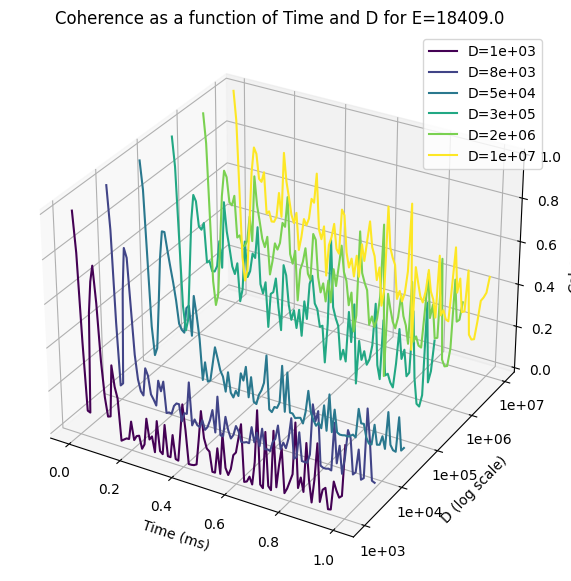

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


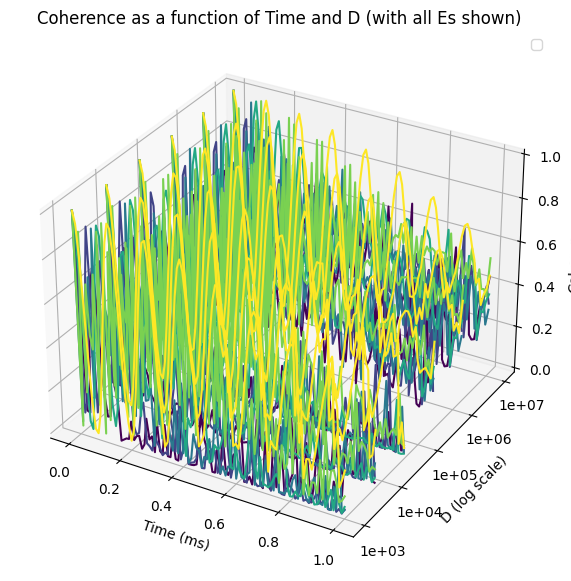

In [ ]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




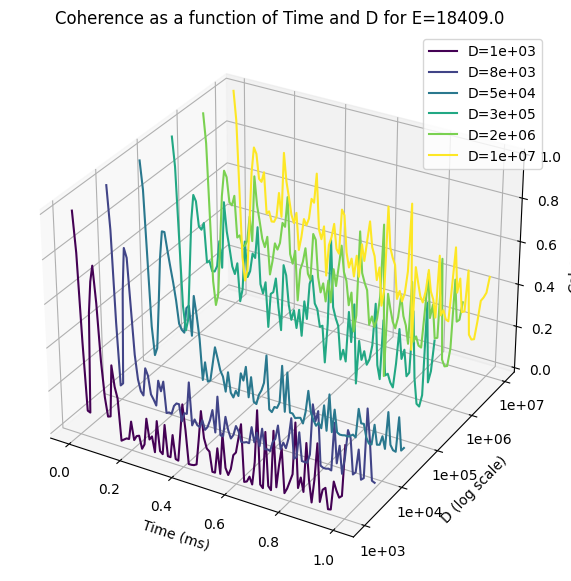

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


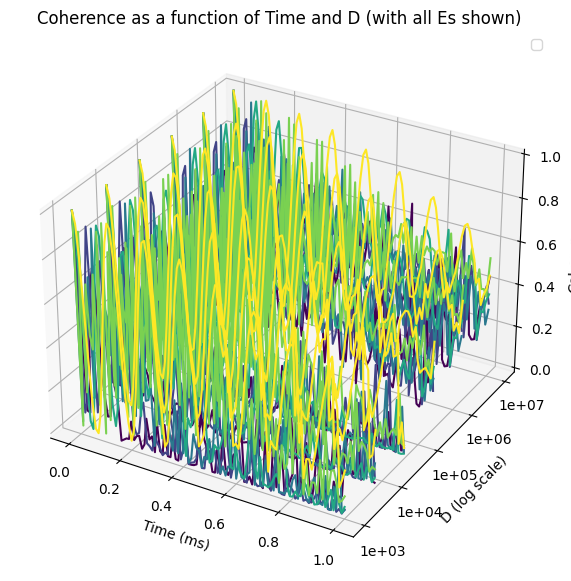

In [ ]:
# 3d plot of coherence as a function of D and E (only showing plots for smallest E value)
# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for the smallest E value
smallest_E = min(unique_E_values)
coherence_matrix_for_smallest_E = np.array([coherence_dict[(D, smallest_E)] for D in unique_D_values])

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting coherence for each D value at the smallest E
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_D_values)))
for i, D_val in enumerate(unique_D_values):
    ax.plot(TIME[i], np.log10([D_val] * len(TIME[i])), coherence_matrix_for_smallest_E[i], color=colors[i], label=f'D={D_val:.0e}')

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title(f'Coherence as a function of Time and D for E={smallest_E}')
ax.legend()

plt.show()








##########################################################################################
# For all E values, plot coherence as a function of D and time

# Convert time_space and unique_D_values to meshgrid
TIME, D = np.meshgrid(time_space, unique_D_values)

# Extract coherence values for each (D, E) pair and store them as a list of 2D arrays
coherence_matrices = [np.array([coherence_dict[(D, E)] for D in unique_D_values]) for E in unique_E_values]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting each E value as a collection of lines (one for each D)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_E_values)))
for i, E in enumerate(unique_E_values):
    for j, D_val in enumerate(unique_D_values):
        ax.plot(TIME[j], np.log10([D_val] * len(TIME[j])), coherence_matrices[i][j], color=colors[i] )#, label=f'E={E}' if j == 0 else "")

# Setting Y-axis (D-axis) ticks and labels for log scale
yticks = np.arange(np.log10(min(unique_D_values)), np.log10(max(unique_D_values)) + 1, 1)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{10**int(tick):.0e}" for tick in yticks])

ax.set_xlabel('Time (ms)')
ax.set_ylabel('D (log scale)')
ax.set_zlabel('Coherence')
ax.set_title('Coherence as a function of Time and D (with all Es shown)')
ax.legend()

plt.show()




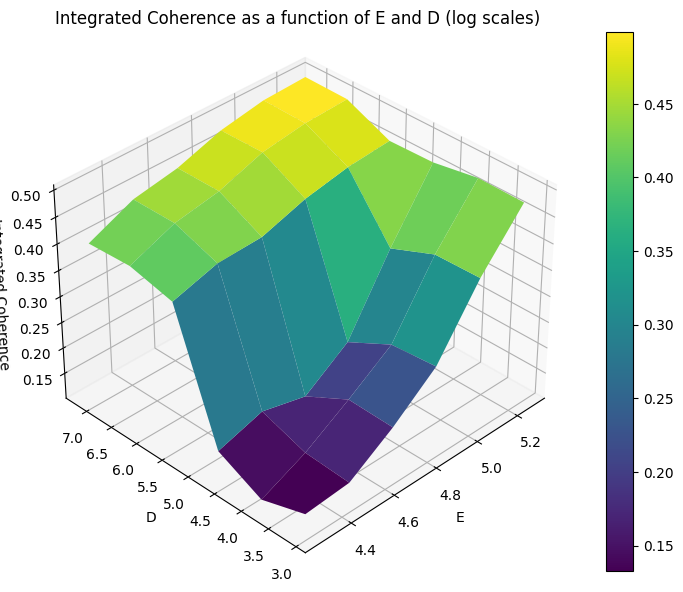

In [ ]:
# Extract unique D and E values
unique_D_values = sorted(set([key[0] for key in coherence_dict.keys()]))
unique_E_values = sorted(set([key[1] for key in coherence_dict.keys()]))

# Create meshgrid for E and D
E, D = np.meshgrid(unique_E_values, unique_D_values)

# Transform values to logarithmic scale
log_unique_D_values = np.log10(unique_D_values)
log_unique_E_values = np.log10(unique_E_values)

# Create meshgrid for log(E) and log(D)
logE, logD = np.meshgrid(log_unique_E_values, log_unique_D_values)

# Calculate integrated coherence for each E, D pair
Z = np.array([[integrate(time_space, coherence_dict[(d, e)]) for e in unique_E_values] for d in unique_D_values])

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(logE, logD, Z, cmap='viridis')
fig.colorbar(surf)

ax.set_xlabel('E')
ax.set_ylabel('D')
ax.set_zlabel('Integrated Coherence')
ax.set_title('Integrated Coherence as a function of E and D (log scales)')
ax.view_init(elev=35, azim=-135)

plt.show()


In [20]:
print(unique_D_values)

[1333.9999999999993, 8416.97097536577, 53107.49655183646, 335085.6499633781, 2114247.5187431253, 13339999.999999994]
